In [6]:
import sys 
import os
sys.path.append(os.path.abspath("/home/pcs/patrick/Dokumente/Github/colormap/"))
import colormaps as cmaps


In [7]:
from __future__ import division

In [8]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [9]:
import numpy as np
import scipy.constants as cs
import scipy.special as ss
import scipy.optimize as so
from matplotlib import pyplot as plt
from matplotlib import cm
from qkit.qkit.gui.notebook.Progress_Bar import Progress_Bar as pb
from scipy.integrate import dblquad
from scipy import integrate
import math as math

%matplotlib inline

In [10]:
#customized plots:
import matplotlib 
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (8.0,5.0)
matplotlib.rcParams['savefig.dpi'] = 100
matplotlib.rcParams['legend.shadow'] = True
matplotlib.rcParams['savefig.bbox'] = 'tight'




cmap_virdis = cmaps.viridis.colors


In [11]:
labelsize = 27

In [12]:
mu_0 = cs.mu_0
mu_B = cs.physical_constants['Bohr magneton'][0]   #Bohr magneton in SI units
k_b = cs.k

### Radial-component Br

In [22]:
#remark: calculation fails if r = 0 and k = 0

def B_r(r,z,z0, I, R, N):
    #B_amp = mu_0*I*R**2./2.
    B_amp = mu_0*I*R**2.*(z-z0)/(2.*np.sqrt((z-z0)**2.))      #introduced a z dependent factor equal to one z/np.sqrt(z**2) but with different sign 
    B = np.float64(0)                                         #below and above the loop
    if np.abs(z-z0) <= 10**(-7):
        #print 'Encountered small number'
        return np.float64(0.)
    else:
        try:
            for k in range(N):
                if r == 0:
                    k +=1
                B += (-1.)**(k+1.)*k*np.power(r,(2.*k-1.))/(2.**k*math.factorial(k))**2.*np.power((z-z0),(-2.*(k+1)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+1,k+3/2.,2., -(R/(z-z0))**2)
            return B_amp*B
        except (RuntimeWarning, ZeroDivisionError):  #changed (-2.*(k+1)) to (-2*k+1)
            print 'ZeroDivisionError encountered' 


### Z-component Bz

In [23]:
#still wrong for z-z0 = 0 since the solution does not depend on r and is only valid for 
#r = 0. Therefore the dimension of the used arrays for r and z should be even!

def B_z(r,z,z0, I, R, N):
    B_amp = mu_0*I*R**2./2.
    B = np.float64(0)
    if np.abs(z-z0) <= 10**(-7):
        #print 'Encountered small number'
        return mu_0*I*R**2./(2.*(R**2.)**(3./2.))
    else:
        try:
            for k in range(N):
                B += (-1.)**(k)*(k+1.)*np.power(r,(2.*k))/(2.**k*math.factorial(k))**2.*np.power(np.abs(z-z0),(-(2.*k+3.)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+3/2.,k+2.,2., -(R/(z-z0))**2.)
            return B_amp*B
        except (RuntimeWarning, ZeroDivisionError):  
            print 'ZeroDivisionError encountered' 
        

## Single loop

In [24]:
def B_SC(r,z,z0,I,R,N):
    '''
    magnetic field of a coil with a single loop
    
    d_wire: wire diameter
    r: radial direction/dimensions
    z: vertical direction/dimensions
    z0: vertical start position
    I: max. current
    R: initial coil radius
    N: number of sqaures'''
    Bz2D = []
    Br2D = []
    for z1 in z:
        Bzr = []
        Brr = []
        for r1 in r:
            Brr.append(B_r(r1,z1,z0,I,R,N))
            Bzr.append(B_z(r1,z1,z0,I,R,N))
        Bz2D.append(Bzr)
        Br2D.append(Brr)
    Bz2D = np.array(Bz2D, dtype=np.float64)
    Br2D = np.array(Br2D, dtype=np.float64)
    return np.array([Bz2D, Br2D],dtype=np.float64)

## Multiple loops

In [25]:
def B_HH(n,n_layer,d_wire,r,z,z0,I,R,N):
    '''magnetic field of a coil of n*n_layer windings, each winding is represented 
    by an individual single loop coil
    
    n: number of windings per layer
    n_layer: total number of layer
    d_wire: wire diameter
    r: radial direction/dimensions
    z: vertical direction/dimensions
    z0: vertical start position
    I: max. current
    R: initial coil radius
    N: number iterations'''
    Ndimr = len(r)
    Ndimz = len(z)
    B_HHr = np.zeros([Ndimr,Ndimz])
    B_HHz = np.zeros([Ndimr,Ndimz])
    
    
    #position = pos(n, n_layer, R, z0, d_wire)
    #startr = int(R/d_wire)
    #startz = int(z0/d_wire)
    
    #removed k: next winding is always placed above the previous one
    
    p1 = pb(n*n_layer)
    for j in range(n_layer):
        #print
        #print R
        #print
        for i in range(n):
            B_HHz += B_SC(r,z,z0,I,R,N)[0]
            B_HHr += B_SC(r,z,z0,I,R,N)[1]
            #print z0
            #position[startz+j][startr+i] += 1
            p1.iterate()
            z0+=d_wire   #the vertical position changes with each added winding/loop
        z0 -= n*d_wire   #
        R += d_wire  #the coil radius increases with every added layer of windings
    return np.array([B_HHz, B_HHr], dtype = np.float64)
        
        
    

In [28]:
def coil_length(n, n_layer, d_wire, R_min):
    l = 0.
    R = R_min
    for i in range(n_layer):
        for j in range(n):
            l += 2.*np.pi*R
        R +=d_wire
    return l

## Calculation parameters

In [13]:
N = 10      #number of terms in sum

R_min = 4.*10**(-3)                   #coil radius in m
R_max = 7.*10**(-3)
d_wire = 0.13*10**(-3.)           #wire diameter in m
z0 = -20.*10**(-3)    #vertical position of coil

n_layer = int((R_max-R_min)/d_wire)      #number of windings per layer
n = int(2.*np.abs(z0)/d_wire)  #number of layer


I_max = 1.                        #max. current in amps



In [128]:
print 'n = {}'.format(n)
print 'n_layer = {}'.format(n_layer)
print
print 'n x d_wire = {} mm '.format(n*d_wire*10**3)

n = 307
n_layer = 23

n x d_wire = 39.91 mm 


In [28]:
n_tot = n*n_layer
print 'n_tot = {}'.format(n_tot)

n_tot = 7061


In [27]:
N_sq = 50
r = np.linspace(-0.9*R_min,0.9*R_min,N_sq)
z = np.linspace(-R_min,R_min,N_sq)
X,Y = np.meshgrid(r,z)


r01 = np.linspace(-0.9*R_min,0.9*R_min,N_sq+1)
z01 = np.linspace(-R_min,R_min,N_sq+1)
X1,Y1 = np.meshgrid(r01,z01)

In [30]:
B = np.array(B_HH(n,n_layer,d_wire,r,z,z0,I_max,R_min,N))



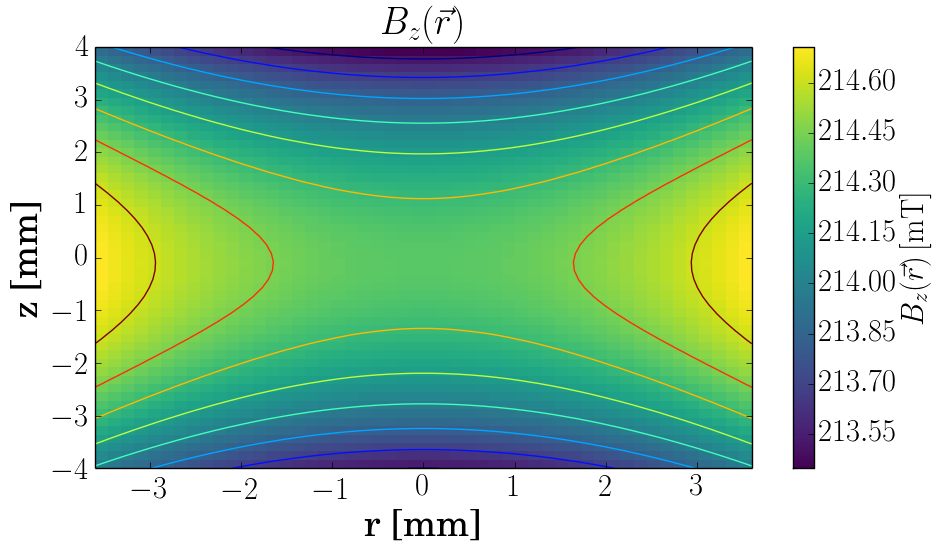

In [55]:
figBz, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R_min*10**3,0.9*R_min*10**3)
ax.set_ylim(-R_min*10**3,R_min*10**3)
#ax.axes.set_aspect('equal')
C2 = plt.contour(r*10**3, z*10**3, B[0]*10**3,10)
cd = plt.pcolor(X1*10**3,Y1*10**3,B[0]*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')
plt.tight_layout()

## Large Compensation coil:

In [17]:
R_c_min = 0.05/2. #inner radius in m
R_c_max = 0.06/2. #max. outer radius in m
l = 0.01 #coil length

In [18]:
n_layer_comp = int((R_c_max-R_c_min)/d_wire)      #number of windings per layer
n_comp = int(l/d_wire)  #number of layer

In [19]:
print n_layer_comp
print n_comp

38
76


In [20]:
n_c_tot = n_layer_comp*n_comp

In [21]:
print n_c_tot

2888


In [29]:
coil_length(n_comp, n_layer_comp, d_wire, R_c_min)

497.28672237532896

In [30]:
N_sq = 50
r_c = np.linspace(-0.9*R_c_min,0.9*R_c_min,N_sq)
z_c = np.linspace(-R_c_min,R_c_min,N_sq)
X_c,Y_c = np.meshgrid(r_c,z_c)


r01_c = np.linspace(-0.9*R_c_min,0.9*R_c_min,N_sq+1)
z01_c = np.linspace(-R_c_min,R_c_min,N_sq+1)
X1_c,Y1_c = np.meshgrid(r01_c,z01_c)

In [31]:
B_compensation = np.array(B_HH(n_comp,n_layer_comp,d_wire,r_c,z_c,-l/2,I_max,R_c_min,N))

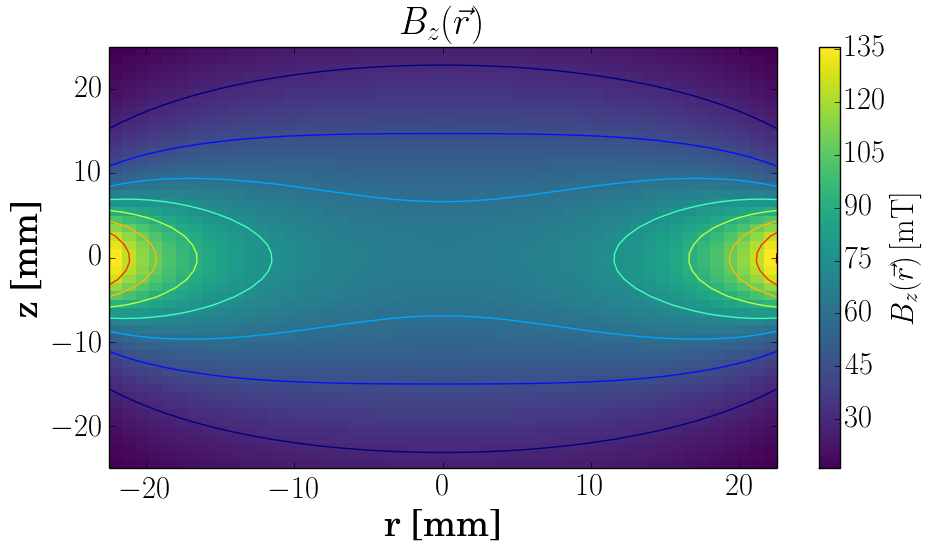

In [32]:
figBz_comp, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R_c_min*10**3,0.9*R_c_min*10**3)
ax.set_ylim(-R_c_min*10**3,R_c_min*10**3)
#ax.axes.set_aspect('equal')
C2 = plt.contour(r_c*10**3, z_c*10**3, B_compensation[0]*10**3,10)
cd = plt.pcolor(X1_c*10**3,Y1_c*10**3,B_compensation[0]*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')
plt.tight_layout()

## Unused functions:

### position detection:

In [130]:
def pos(n, n_layer, R, z0, d_wire, HH = True):
    '''creates an numpy zero array; dimensions are calculated from
    the maximum coil dimensions divided by the wire diameter
    '''
    if HH == True:
        Ndimz = int(2.*(np.abs(z0)+n*d_wire)/d_wire)
    else: 
        Ndimz = int(2.*(np.abs(z0))/d_wire)
    if np.mod(Ndimz,2) != 0:
        Ndimz += 1
    Ndimr = int(2.*(R+n_layer*d_wire)/d_wire)
    if np.mod(Ndimr,2) != 0:
        Ndimr += 1    
    pos = np.zeros([Ndimz, Ndimr])
    return pos

In [131]:
def test_func(n, n_layer, R, z0, d_wire, k = 1 , HH = True ):
    position = pos(n, n_layer, R, z0, d_wire, HH)
    startr = int((R+n_layer*d_wire)/d_wire-R/d_wire)
    #p1 = pb(n*n_layer)
    if(z0 >= 0):    #distrincion between a coil above or below the waveguide
        startz = int((2.*z0+n*d_wire)/d_wire)
    else: 
        if k == 1:
            startz = 0
        else:
            startz = int(n)
    print 'n = {}'.format(n)
    print 'n_layer = {}'.format(n_layer)
    print 'n_tot = {}'.format(n*n_layer)  
    print 'z_coil = n_tot x d_wire = {} mm '.format(n*d_wire*10**3)
    print 'z0 = {} mm'.format(z0*10**3)
    print 'startr = {}'.format(startr)
    print 'startz = {}'.format(startz)
    for j in range(n_layer):
        for i in range(n):
            #print z0
            #position[j][i] = 1
            position[startz+k*i][startr-j] += 1
            position[startz+k*i][position.shape[1]-startr+j] += 1
            #p1.iterate()
            z0+=k*d_wire   #the vertical position changes with each added winding/loop
        z0 -= k*n*d_wire   #
        R += d_wire  #the coil radius increases with every added layer of windings
    return np.array(position)

In [125]:
z_test[n]

-0.0066366666666666692

In [132]:
test_pos = test_func(n, n_layer, R_min, z0, d_wire, HH = False)

n = 307
n_layer = 23
n_tot = 7061
z_coil = n_tot x d_wire = 39.91 mm 
z0 = -20.0 mm
startr = 23
startz = 0


In [137]:
posi = pos(n, n_layer, R_min, z0, d_wire, HH = False)

In [138]:
posi.shape

(308, 108)

In [139]:
r_test = np.linspace(-(R_min+n_layer*d_wire), +(R_min+n_layer*d_wire), posi.shape[1])
z_test = np.linspace(-(z0+n*d_wire), +(z0+n*d_wire), posi.shape[0])

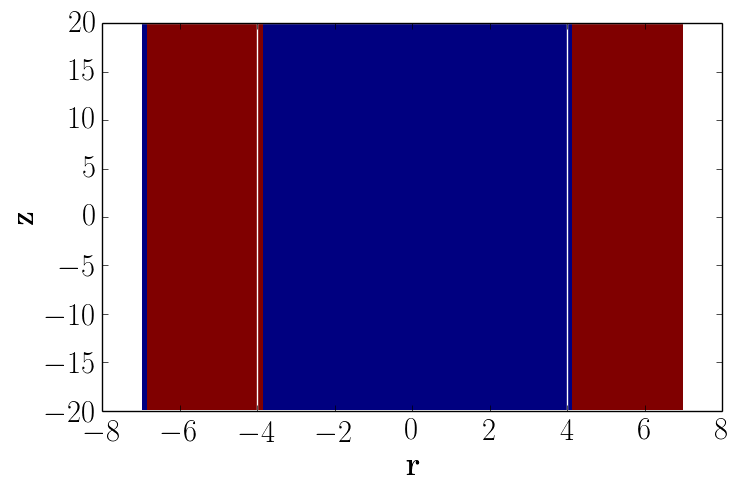

In [140]:
plt.pcolor(r_test*10**3, z_test*10**3, test_pos)
plt.axvline(-R_min*10**3, color = 'white')
plt.axvline(R_min*10**3, color = 'white')
plt.axhline(-z0*10**3, color = 'white')
plt.axhline(z0*10**3, color = 'white')

#plt.axvline(r_test[20]*10**3, color = 'red')
#plt.axhline(z_test[49]*10**3, color = 'red')
plt.xlabel('r')
plt.ylabel('z')